# LoreFinder Notebook

## Table of Contents

[Introduction](#introlib)

1. [Introduction](#intro)
1. [Librairies, Config & APIs](#lib)
1. [Scrapping](#scrapping)

[Chapter 1 : Data Analysis & Visualization](#chapter1)

1. [Section 1.1](#section_1_1)
1. [Section 1.2](#section_1_2)
1. [Section 1.3](#section_1_3)

[Chapter 2 : Models](#chapter2)

1. [Section 2.1 : Classification](#section_2_1)
1. [Section 2.2 : Generation](#section_2_2)
    1. [Section 2.2.1 : Generation Synopsis](#section_2_2_1)
    1. [Section 2.2.2 : Generation Poster](#section_2_2_2)

[Chapter 3 : App](#chapter3)

1. [Section 3.1 : All](#section_3_1)
1. [Section 3.2 : TV Shows](#section_3_2)
1. [Section 3.3 : Movies](#section_3_3)

### Introduction & Librairies <a class="anchor" id="introlib"></a>

#### Introduction <a class="anchor" id="intro"></a>

##### What is this ?

- This is a potential creative app that uses generative models as a playground for users to generate overview of movies & tv show. It's mostly an app to learn about using and fine-tuning HuggingFace models like BERT & GPT-2.

##### What is this notebook ? Wouldn't python script be easier ?

- This is the Notebook used to make all the preparations to make a python backend for the app. Using a notebook makes it easier to experiment and also for the exploratory data analysis that'll be first made to explore the data we have to work with. Once experimentation is done, we can extract the code and put it in a lib that will be pushed into a git repository and used in the final demo & app.

##### Why this app/idea ?

- Because it enables me to learn more about how Hugging Face is used to produce models used in production. Hugging Face has become the face of NLP models and being able to use a pre-existing model and fine-tune it to fit a need is a skill that I wanted to train on.

#### Librairies, Config & APIs <a class="anchor" id="lib"></a>

This is where all the import & config happens.

The biggest import are :

| Librairies | What it's used for |
| ---- | ---- |
| Pandas & Numpy | Process & Handling of the data |
| Pyplot, Plotly & Seaborn | Visualize the data |
| Tensorflow & Keras | Deep Learning backend & framework |
| Transformers & Diffusers | Deep Learning NLP models |

We also need to config the API key for TMDB to be able to scrap the database and an HF token to be able to push fine-tuned model to the Hugging Face Hub.

In [2]:
import os
import glob
import json
import requests
import calendar

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf

from transformers import AutoTokenizer, create_optimizer, AdamWeightDecay, DataCollatorWithPadding, TFAutoModelForSequenceClassification, TFAutoModelForCausalLM

from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from keras.callbacks import TensorBoard
import evaluate

from datasets import Dataset

from diffusers import DiffusionPipeline, LCMScheduler

HF_TOKEN = os.environ['HF_TOKEN']
API_KEY = os.environ["TMDB_API_KEY"]
API_VERSION = 3
API_BASE_URL = f"https://api.themoviedb.org/{API_VERSION}"
RANDOM_STATE = 21

2023-11-28 12:35:18.255965: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 12:35:18.380152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 12:35:18.380208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 12:35:18.380427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 12:35:18.435497: I tensorflow/core/platform/cpu_feature_g

#### Scrapping TMDB <a class="anchor" id="scrapping"></a>

Using TMDB's API, we can scrape the database using a function that will cycle through every movies & tv shows id to get the details. Unfortunatly there's no way around this except choosing another database and TMDB doesn't offer images of their database, offering only an API service limited to 40 requests per second. This makes the scrapping a very heavy process. [You can get the script here](./scripts/scrapper.py)

```python
from scripts import Scraper_TMDB

## Movies
Scraper_TMDB('./data/jsons/04_11_2023/ids/movie_ids_04_11_2023.json', './data/jsons/04_11_2023/movie', 10, 'movie', API_BASE_URL, API_KEY)

## TV Shows
Scraper_TMDB('./data/jsons/04_11_2023/ids/tv_series_ids_04_11_2023.json', './data/jsons/04_11_2023/tv', 10, 'tv', API_BASE_URL, API_KEY)
```

### Chapter 1 : Data Analysis & Vizualisation<a class="anchor" id="chapter1"></a>

#### Section 1.1 : Building the dataset <a class="anchor" id="section_1_1"></a>

After using the scrapper, we're left with multiple json that we can load with pandas using the function defined below

In [1]:
def get_json(file):
    with open(file) as f:
        data = json.load(f)
    return data

def get_df_from_json_folder(filepath, cols=[]):
    json_pattern = os.path.join(filepath, '*.json')
    list_of_files = glob.glob(json_pattern)

    list_of_files.sort(key=lambda x: int(
        os.path.splitext(x)[0].split('-')[1]
    ))
    
    dfs = [pd.DataFrame(get_json(file)).T for file in list_of_files]

    return pd.concat(dfs, ignore_index=True)[cols] if cols else pd.concat(dfs, ignore_index=True)

In [3]:
series_columns = ['backdrop_path', 'created_by', 'episode_run_time', 'first_air_date', 'genres', 'in_production', 'languages', 'last_air_date', 'last_episode_to_air', 'name', 'networks', 'number_of_episodes', 'number_of_seasons', 'origin_country', 'original_language', 'original_name', 'overview', 'popularity', 'production_companies', 'production_countries', 'seasons', 'spoken_languages', 'status', 'tagline', 'type', 'vote_average', 'vote_count']

movies_columns = ['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']

df_movies_raw = get_df_from_json_folder('./data/jsons/04_11_2023/movie', movies_columns)

df_series_raw = get_df_from_json_folder('./data/jsons/04_11_2023/tv', series_columns)

#### Section 2.2 : EDA <a class="anchor" id="section_2_2"></a>

Preprocessing data for EDA, we start by filtering columns that aren't useful for data analysis and revealing where the NaNs values are.

In [4]:
def preprocess_df(df_raw, col_list, col_process_list):
    result_df = df_raw[col_list].copy()
    result_df = result_df.mask(result_df == '').mask(result_df.map(str).eq('[]'))

    for col in col_process_list:
        result_df[col] = result_df[col].apply(lambda row : [dicts['name'] for dicts in row] if type(row) == list else row)
        
    return result_df

In [5]:
movies_eda_columns = ['belongs_to_collection', 'budget', 'genres', 'homepage', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']

movies_cols_to_process = ['genres', 'production_companies', 'production_countries']

df_movies = preprocess_df(df_movies_raw, movies_eda_columns, movies_cols_to_process)

df_movies['belongs_to_collection'] = df_movies['belongs_to_collection'].fillna(value=np.nan).apply(lambda row: row['name'] if type(row) == dict else row)

In [6]:
series_eda_columns = ['created_by', 'episode_run_time', 'first_air_date', 'genres', 'in_production', 'languages', 'last_air_date', 'name', 'networks', 'number_of_episodes', 'number_of_seasons', 'origin_country', 'original_language', 'original_name', 'overview', 'popularity', 'production_companies', 'production_countries', 'seasons', 'spoken_languages', 'status', 'tagline', 'type', 'vote_average', 'vote_count']

series_cols_to_process = ['created_by', 'genres', 'networks', 'production_companies', 'production_countries', 'seasons']

df_series = preprocess_df(df_series_raw, series_eda_columns, series_cols_to_process)

In [7]:
for df in [df_movies, df_series]:
    df['spoken_languages'] = df['spoken_languages'].apply(lambda row: [dicts['english_name'] for dicts in row] if type(row) == list else row)

We can now look at the data once it's been preprocessed

In [12]:
print(df_movies.shape)
df_movies.head(2)

(859971, 19)


,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,Blondie Collection,0,"[Comedy, Family]",NaN,en,Blondie,Blondie and Dagwood are about to celebrate the...,2.5,[Columbia Pictures],[United States of America],1938-11-30,0,70,[English],Released,The favorite comic strip of millions at last o...,Blondie,7.2,7
1,NaN,0,[Adventure],NaN,de,Der Mann ohne Namen,NaN,1.091,NaN,[Germany],1921-01-01,0,420,NaN,Released,NaN,"Peter Voss, Thief of Millions",0.0,0


In [13]:
print(df_series.shape)
df_series.head(2)

(158626, 25)


,created_by,episode_run_time,first_air_date,genres,in_production,languages,last_air_date,name,networks,number_of_episodes,...,popularity,production_companies,production_countries,seasons,spoken_languages,status,tagline,type,vote_average,vote_count
0,NaN,[60],2004-01-12,[Drama],False,[ja],2004-03-22,Pride,[Fuji TV],11,...,18.171,NaN,[Japan],[Season 1],[Japanese],Ended,NaN,Scripted,8.2,13
1,"[Kevin Smith, Scott Mosier, David Mandel]",[22],2000-05-31,"[Animation, Comedy]",False,[en],2002-12-22,Clerks,"[ABC, Comedy Central]",6,...,31.201,"[Touchstone Television, View Askew Productions...",[United States of America],"[Specials, Season 1]",[English],Canceled,NaN,Scripted,7.012,86


Now one important thing to look for is NaN values, we used the preprocessing step to highlight NaNs from void values (like empty lists or strings) so we can visualize them in a proper way, we can for that use a barchart or a heatmap

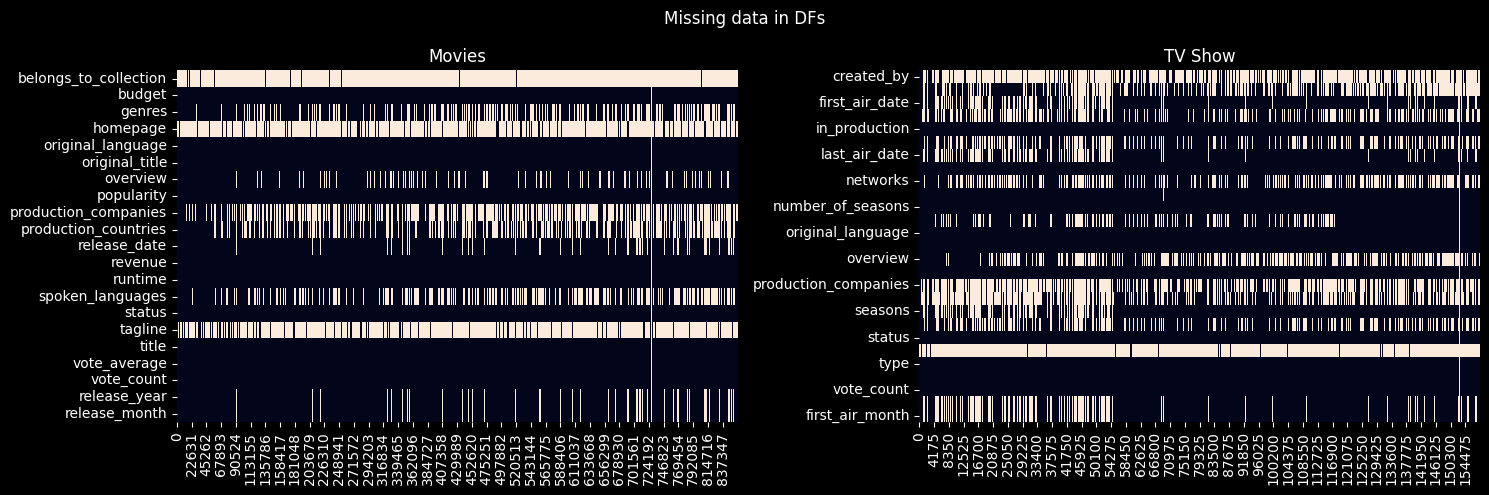

In [35]:
nan_plot_dict = {
    "Movies" : df_movies.isna().T,
    "TV Show" : df_series.isna().T
    }

plt.subplots(figsize=(15,5))
plt.axis('off')
plt.suptitle('Missing data in DFs')
index = 1
for k,v in nan_plot_dict.items():
    plt.subplot(1,2,index)
    plt.title(k)
    sns.heatmap(v, cbar=False)
    index += 1
plt.tight_layout()
plt.savefig('./viz/nan_heatmap.png')

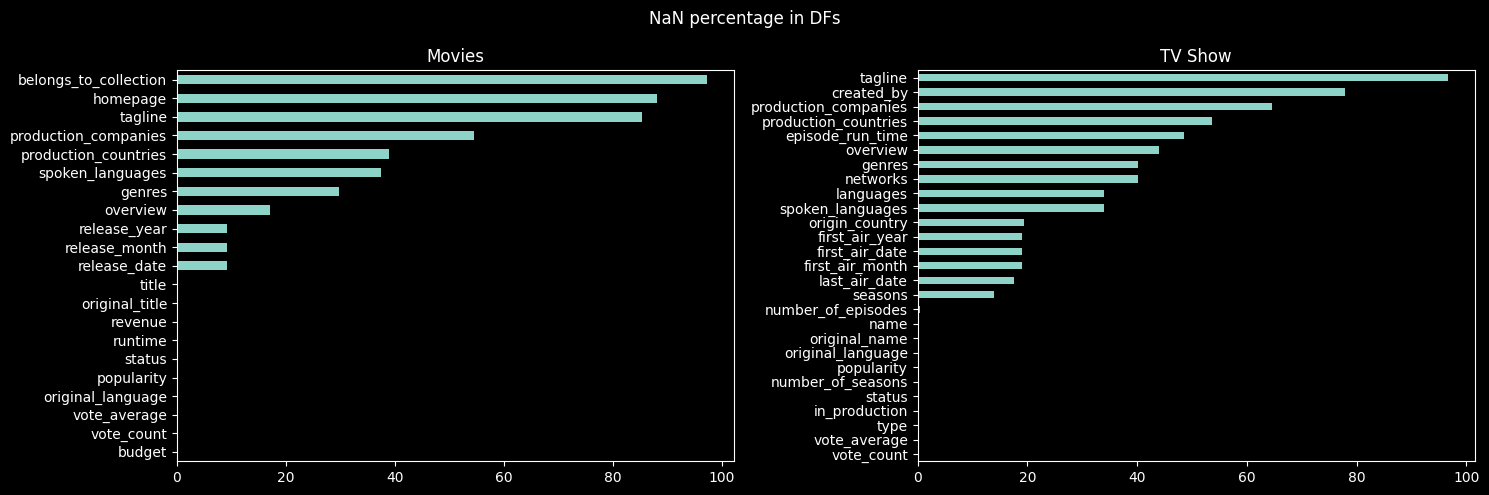

In [36]:
nan_percentage_dict = {
    "Movies" : df_movies.isna().sum().sort_values(ascending=True) / len(df_movies) * 100,
    "TV Show" : df_series.isna().sum().sort_values(ascending=True) / len(df_series) * 100
    }

plt.subplots(figsize=(15,5))
plt.axis('off')
plt.suptitle('NaN percentage in DFs')
index = 1
for k,v in nan_percentage_dict.items():
    plt.subplot(1,2,index)
    plt.title(k)
    v.plot(kind='barh')
    index += 1
plt.tight_layout()
plt.savefig('./viz/nan_percent.png')

Now we can see that some columns have a lot of missing data. What we're interested in for generating overview & classifying genres are the `overview` & `genres` features. We're missing a lot of overview & genres in TV show and a little bit less overview are missing in movies. We can therefore see if we can train a model to infer those missing genres since trying to generate convincing overview based on title & genres seems a bit too difficult.

We can now try to have some general visualization of the data like the language

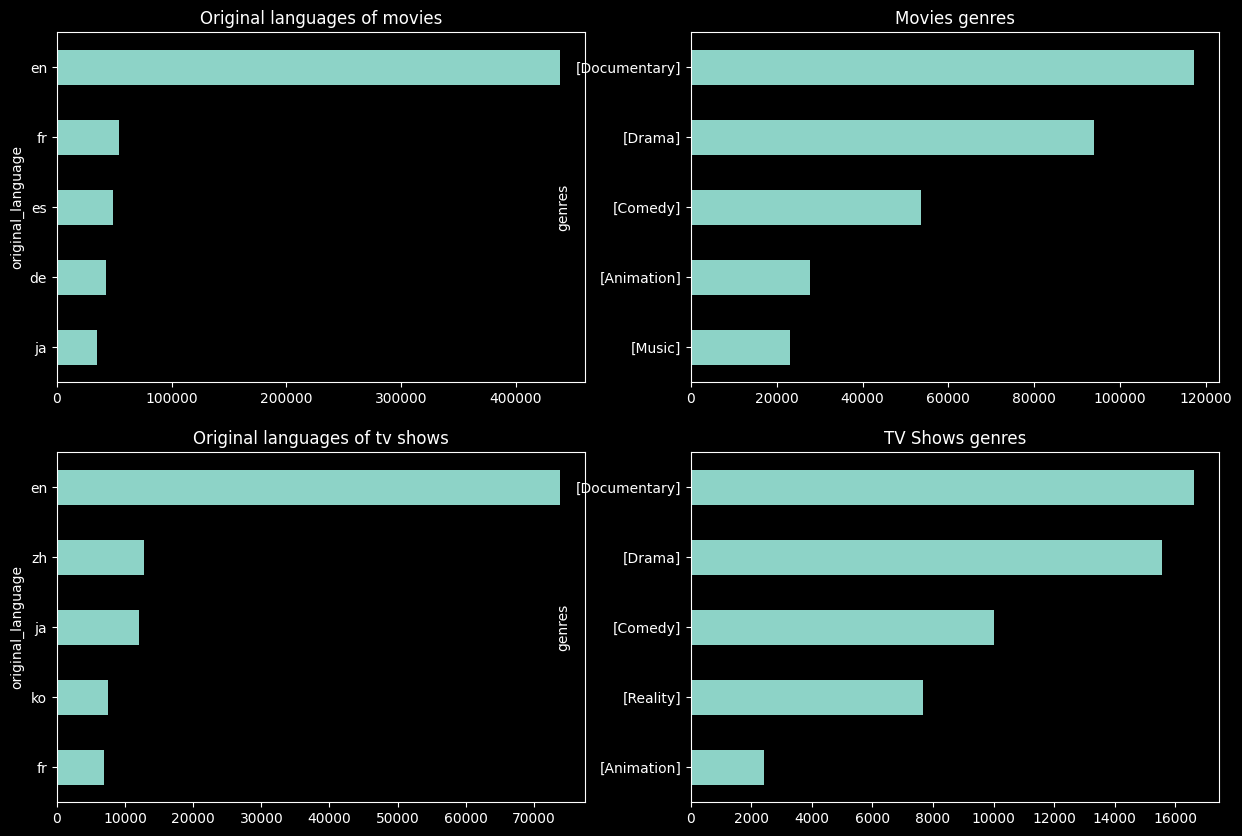

In [37]:
plot_dict_movies = {
    "Original languages of movies" : 
    df_movies['original_language'].value_counts().head().sort_values(ascending=True),
    "Movies genres" :
    df_movies['genres'].value_counts().head().sort_values(ascending=True),
    "Original languages of tv shows" : 
    df_series['original_language'].value_counts().head().sort_values(ascending=True),
    "TV Shows genres" : 
    df_series['genres'].value_counts().head().sort_values(ascending=True)
}

plt.subplots(figsize=(15,10))
plt.axis('off')
index = 1
for key, value in plot_dict_movies.items():
    plt.subplot(2,2, index)
    plt.title(key)
    value.plot(kind='barh')
    index += 1
plt.savefig('./viz/languages_genres.png')

In [31]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_series['first_air_date'] = pd.to_datetime(df_series['first_air_date'], errors='coerce')

df_movies['release_year'] = df_movies['release_date'].dt.year 
df_movies['release_month'] = df_movies['release_date'].dt.month 

df_series['first_air_year'] = df_series['first_air_date'].dt.year 
df_series['first_air_month'] = df_series['first_air_date'].dt.month

print('TV Shows Air Date NaNs :', (df_series['first_air_date'].dt.year).isna().sum(), '\nMovies Air Date NaNs :', (df_movies['release_date'].dt.year).isna().sum())

TV Shows Air Date NaNs : 30083 
Movies Air Date NaNs : 79628


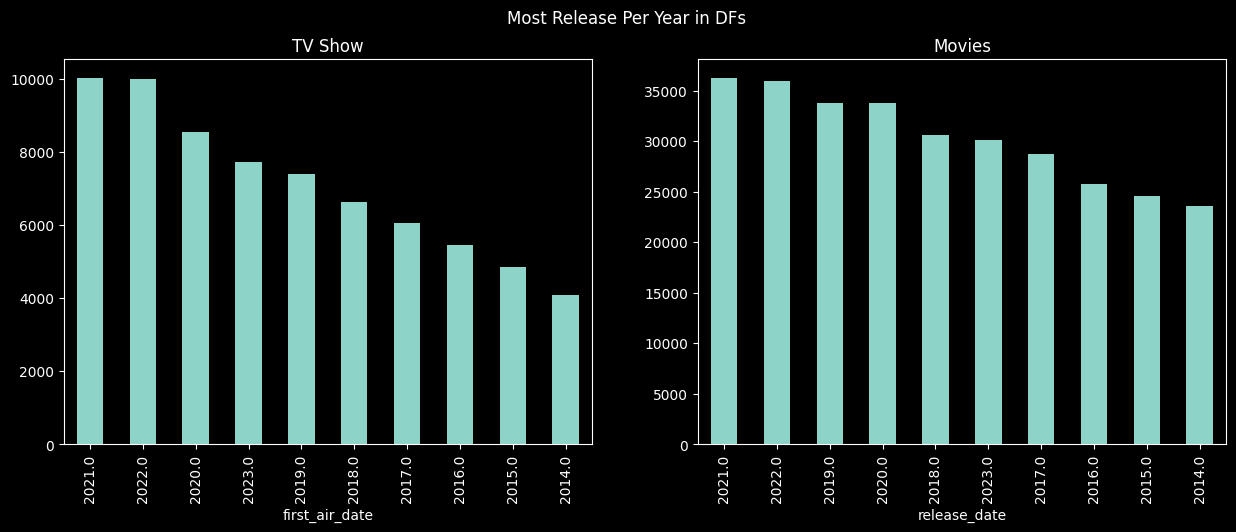

In [38]:
plot_dict = {
    "TV Show" : df_series['first_air_date'].dt.year.value_counts().head(10), 
    "Movies" : df_movies['release_date'].dt.year.value_counts().head(10)
    }

plt.subplots(figsize=(15,5))
plt.axis('off')
plt.suptitle('Most Release Per Year in DFs')
index = 1
for k,v in plot_dict.items():
    plt.subplot(1,2,index)
    plt.title(k)
    v.plot(kind='bar')
    index += 1
plt.savefig('./viz/release_year.png')

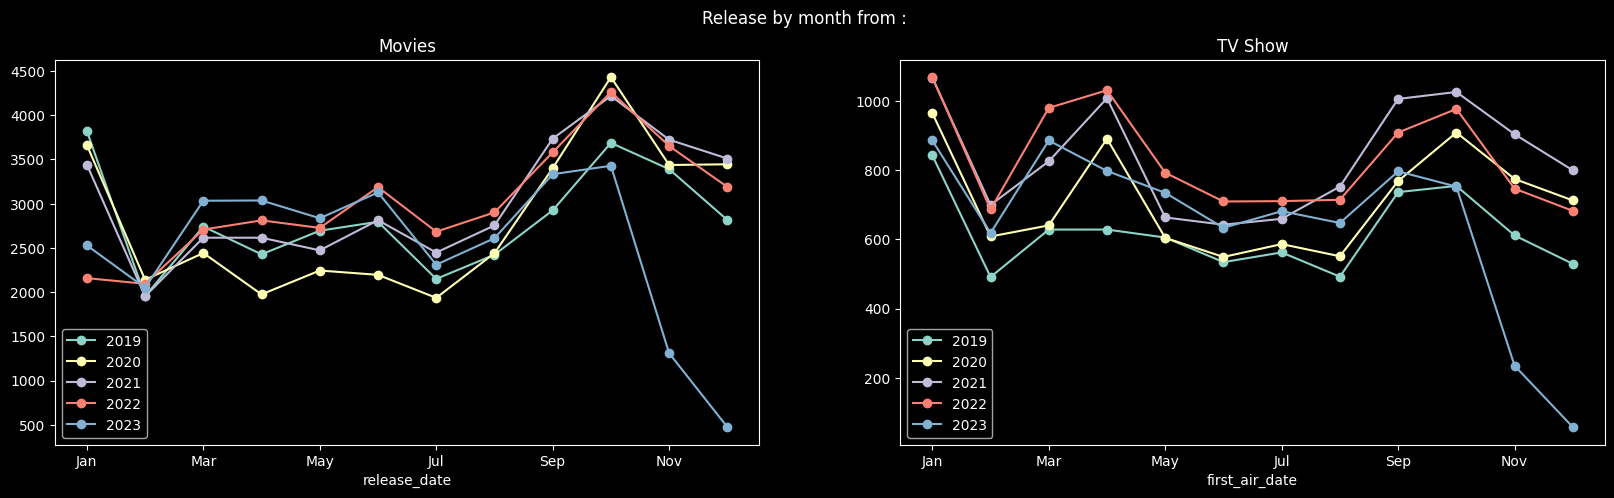

In [39]:
start_year, end_year = 2019, 2023
year_list = [i for i in range(start_year, end_year + 1)]

plot_list = [[df_movies, 'release_date'], [df_series, 'first_air_date']]
title_list = ['Movies', 'TV Show']

def get_count_by_month(df, col, year):
    result = df[df[col].dt.year == year][col].dt.strftime("%b").value_counts().reindex(calendar.month_abbr[1:])
    return result

plt.subplots(figsize=(20,5))
plt.axis('off')
plt.suptitle('Release by month from :')
for index in range(2):
    plt.subplot(1, 2, index + 1)
    plt.title(title_list[index])
    for year in year_list:
        get_count_by_month(plot_list[index][0], plot_list[index][1], year).plot(marker='o')
    plt.legend(year_list[:])
plt.savefig('./viz/release_month.png')

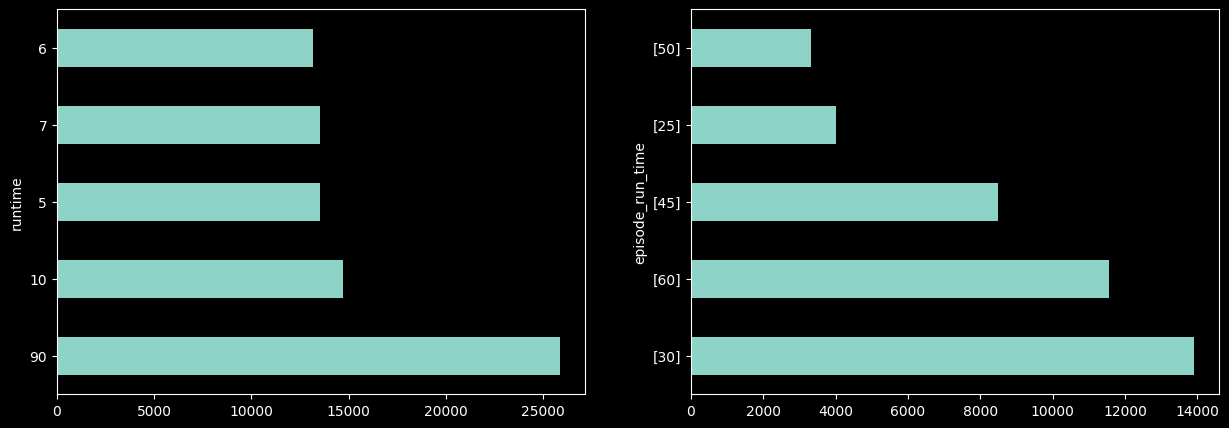

In [40]:
plots = [df_movies[df_movies['runtime'] != 0]['runtime'],
df_series['episode_run_time']]

index = 1
plt.subplots(figsize=(15,5))
plt.axis('off')
for each in plots:
    plt.subplot(1,2,index)
    each.value_counts().head().plot(kind='barh')
    index += 1
plt.savefig('./viz/runtime.png')

In [12]:
plot_dict = {
    "TV Show per countries" : df_series['production_countries'].explode().dropna().value_counts(), 
    "Movies per countries" : df_movies['production_countries'].explode().dropna().value_counts()
    }

for title, plot in plot_dict.items():
    fig = go.Figure(data=go.Choropleth(locationmode='country names',  locations=plot.index.values, text=plot.index, z=plot.values, colorscale = 'Greys'))
    fig.update_layout(height=600, width=800, title_text=title,title_x=0.5)
    fig.show()

### Chapter 2 : Models <a class="anchor" id="chapter2"></a>

LoreFinder has 2 principal functionnality that require AI to be solved :
- Classification overviews into genre :  
    - The user write an overview and the model tells us which genre this overview fits into
- Generation of overviews from genres & title :  
    - The user write a title & select genres, the model give us an overview that fits the title & genres

#### Section 2.1 : Classification <a class="anchor" id="section_2_1"></a>

Classify genres based on overview, the model we'll use is a simple random forest which is nice for categorical data

In [44]:
cols = ['genres', 'overview', 'title']

df_clf = pd.concat([
    df_movies[df_movies['overview'].notna()],
    df_series[df_series['overview'].notna()].rename(columns={'name' : 'title'})
    ], ignore_index=True)[cols].rename(columns={'genres' : 'label'})

In [45]:
def filter_dominant_genres(genres_list):
    dominants_genres_list = ['Drama', 'Documentary', 'Comedy', 'Animation', 'Horror']
    if len(genres_list) > 1 and genres_list[0] in dominants_genres_list:
        processed_genres = [genre for genre in genres_list if genre not in dominants_genres_list]
        result = processed_genres[0] if len(processed_genres) > 0 else genres_list[0]
        return result
    else:
        return genres_list[0]

In [46]:
replace_dict = {
    'Sci-Fi & Fantasy' : 'Science Fiction',
    'War & Politics' : 'History',
    'Musical' : 'Music',
    'News' : 'Reality',
    'Talk' : 'Reality',
    'Soap' : 'Drama',
    'Kids' : 'Family',
    'Action & Adventure' : 'Adventure',
    'War' : 'History'
}

df_clf['label'] = df_clf['label'].apply(lambda row : filter_dominant_genres(row) if type(row) == list else row).replace(replace_dict)

df_clf['text'] = df_clf['title'] + ' | ' + df_clf['overview']

candidates = df_clf['label'].value_counts().index.to_list()

In [47]:
df_clf_to_train = df_clf[~df_clf['label'].isna()].copy()
df_clf_to_train.shape

(571212, 4)

In [48]:
genre_index = df_clf_to_train['label'].factorize()[1]

df_clf_to_train['label'] = df_clf_to_train['label'].factorize()[0]

df_clf_to_train.head()

,label,overview,title,text
0,0,Blondie and Dagwood are about to celebrate the...,Blondie,Blondie | Blondie and Dagwood are about to cel...
1,1,Love at Twenty unites five directors from five...,Love at Twenty,Love at Twenty | Love at Twenty unites five di...
3,0,"Elmo is making a very, very super special surp...",Sesame Street: Elmo Loves You!,Sesame Street: Elmo Loves You! | Elmo is makin...
4,1,After the coal mine he works at closes and his...,Ariel,Ariel | After the coal mine he works at closes...
5,1,"Nikander, a rubbish collector and would-be ent...",Shadows in Paradise,"Shadows in Paradise | Nikander, a rubbish coll..."


In [23]:
tokenizer_clf = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_classifier(examples):
    return tokenizer_clf(examples["text"], truncation=True)

cols = ['text', 'label']

raw_datasets = Dataset.from_pandas(df_clf_to_train[cols], preserve_index=True).train_test_split(seed=RANDOM_STATE)

tokenized_dataset = raw_datasets.map(tokenize_classifier, batched=True, remove_columns=['__index_level_0__'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_clf, return_tensors="tf")

Map:   0%|          | 0/428409 [00:00<?, ? examples/s]

Map:   0%|          | 0/142803 [00:00<?, ? examples/s]

In [24]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [25]:
n_label = len(genre_index)

id2label = {id:genre_index[id] for id in range(n_label)}
label2id = {genre_index[id]:id for id in range(n_label)}

In [26]:
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

model_clf = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=n_label, id2label=id2label, label2id=label2id
)

tf_train_set = model_clf.prepare_tf_dataset(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator,
)

tf_validation_set = model_clf.prepare_tf_dataset(
    tokenized_dataset["test"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

model_clf.compile(optimizer=optimizer)

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

push_to_hub_callback = PushToHubCallback(
    output_dir="overview_classifier_final",
    tokenizer=tokenizer_clf,
)

tensorboard_callback = TensorBoard(log_dir="./overview_classifier_final/logs")

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

model_clf.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

2023-11-25 00:08:41.652008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 00:08:41.671413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 00:08:41.671587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 00:08:41.675123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 00:08:41.675337: I tensorflow/compile

Epoch 1/3


2023-11-25 00:08:58.792376: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fea6190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 00:08:58.792414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-11-25 00:08:58.799206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 00:08:58.850631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-25 00:08:58.910458: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53551/53551 [==============================] - 6487s 121ms/step - loss: 1.4370 - val_loss: 1.3354 - accuracy: 0.5644
Epoch 2/3
53551/53551 [==============================] - 5988s 112ms/step - loss: 1.1724 - val_loss: 1.3251 - accuracy: 0.5701
Epoch 3/3
53551/53551 [==============================] - 5753s 107ms/step - loss: 1.1282 - val_loss: 1.3251 - accuracy: 0.5701


#### Section 2.2 : Generation <a class="anchor" id="section_2_2"></a>

##### Section 2.2.1 : Synopsis Generation <a class="anchor" id="section_2_2_1"></a>

To generate synopsis, we will fine-tune a GPT-2 model using the title, genre and overview of either a movie or tv show and check how it behave. We will use the classifier we just fine-tuned to predict missing genres.

First we get a dataframe with only missing genres

In [27]:
df_clf_to_pred = df_clf[df_clf['label'].isna()].dropna(subset=['title']).copy()

df_clf_to_pred.shape

(230912, 4)

We load the model we just pushed to the hugging_face hub so we're sure we always use the latest version and we make a function that'll infer the genre of a title + overview input

In [28]:
def get_pred_genre(input, tokenizer, model):
    tokenized_input = tokenizer(input, max_length=512, truncation=True, padding='max_length', return_tensors="tf")
    logits = model(**tokenized_input).logits
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    return model.config.id2label[predicted_class_id]

In [29]:
df_clf_to_pred['label'] = df_clf_to_pred.apply(lambda row: get_pred_genre(row['text'], tokenizer_clf, model_clf), axis=1)
df_clf_to_pred['text'] = df_clf_to_pred['title'] + ' | ' + df_clf_to_pred['label'] + ' | ' + df_clf_to_pred['overview']

df_clf_to_train['label'] = df_clf_to_train['label'].replace(id2label)
df_clf_to_train['text'] = df_clf_to_train['title'] + ' | ' + df_clf_to_train['label'] + ' | ' + df_clf_to_train['overview']

In [30]:
cols = ['genres', 'text']

df_gen = pd.concat([df_clf_to_train, df_clf_to_pred])

In [31]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_gen = TFAutoModelForCausalLM.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [32]:
def generate_synopsis(model, tokenizer, title):
    input_ids = tokenizer(title, return_tensors="tf")
    output = model.generate(input_ids['input_ids'], max_length=150, num_beams=5, no_repeat_ngram_size=2, top_k=50, attention_mask=input_ids['attention_mask'])
    synopsis = tokenizer.decode(output[0], skip_special_tokens=True)
    return synopsis

prompt = "Blondie | Family | "

print(f"Model output before fine-tuning: {generate_synopsis(model_gen, tokenizer, prompt)}\nWhat we're expecting : {df_gen.iloc[0]['text']}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model output before fine-tuning: Blondie | Family | __________________
What we're expecting : Blondie | Family | Blondie and Dagwood are about to celebrate their fifth wedding anniversary but this happy occasion is marred when the bumbling Dagwood gets himself involved in a scheme that is promising financial ruin for the Bumstead family.


We can see the model's result aren't what we're expecting, but now we can fine-tune and see if it improves our model output

In [33]:
def tokenize_generator(examples):
    return tokenizer(examples["text"])

raw_datasets = Dataset.from_pandas(df_gen, preserve_index=True).train_test_split(seed=RANDOM_STATE)

tokenized_datasets = raw_datasets.map(
    tokenize_generator, batched=True, remove_columns=['title', 'overview', 'text', 'label', '__index_level_0__']
)

def group_texts(examples, block_size = 128):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

Map:   0%|          | 0/601593 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1076 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/200531 [00:00<?, ? examples/s]

In [34]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
)

Map:   0%|          | 0/601593 [00:00<?, ? examples/s]

Map:   0%|          | 0/200531 [00:00<?, ? examples/s]

In [35]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
)

optimizer = AdamWeightDecay(lr=2e-5, weight_decay_rate=0.01)

model_gen.compile(optimizer=optimizer)

train_set = model_gen.prepare_tf_dataset(
    lm_datasets["train"],
    shuffle=True,
    batch_size=8,
)

validation_set = model_gen.prepare_tf_dataset(
    lm_datasets["test"],
    shuffle=False,
    batch_size=8,
)

tensorboard_callback = TensorBoard(log_dir="./distilgpt2-finetuned-synopsis-genres_final/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./distilgpt2-finetuned-synopsis-genres_final",
    tokenizer=tokenizer
)

callbacks = [tensorboard_callback, push_to_hub_callback]

model_gen.fit(train_set, validation_data=validation_set, epochs=4, callbacks=callbacks)

model_gen.save_pretrained("./data/model/distilgpt2-finetuned-synopsis-genres_final")

Map:   0%|          | 0/601593 [00:00<?, ? examples/s]

Map:   0%|          | 0/200531 [00:00<?, ? examples/s]

/home/alel/.local/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
Cloning https://huggingface.co/Alirani/distilgpt2-finetuned-synopsis-genres_final into local empty directory.


Epoch 1/4
    6/40901 [..............................] - ETA: 1:20:22 - loss: 4.5849WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0315s vs `on_train_batch_end` time: 0.0793s). Check your callbacks.


40901/40901 [==============================] - 5120s 125ms/step - loss: 4.0094 - val_loss: 3.8307
Epoch 2/4
40901/40901 [==============================] - 5655s 138ms/step - loss: 3.8810 - val_loss: 3.7803
Epoch 3/4
40901/40901 [==============================] - 6510s 159ms/step - loss: 3.8211 - val_loss: 3.7502
Epoch 4/4
40901/40901 [==============================] - 6037s 148ms/step - loss: 3.7786 - val_loss: 3.7310


##### Section 3.2.2 : Poster Generation <a class="anchor" id="section_3_2_2"></a>

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]
The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
100%|██████████| 4/4 [14:32<00:00, 218.20s/it]


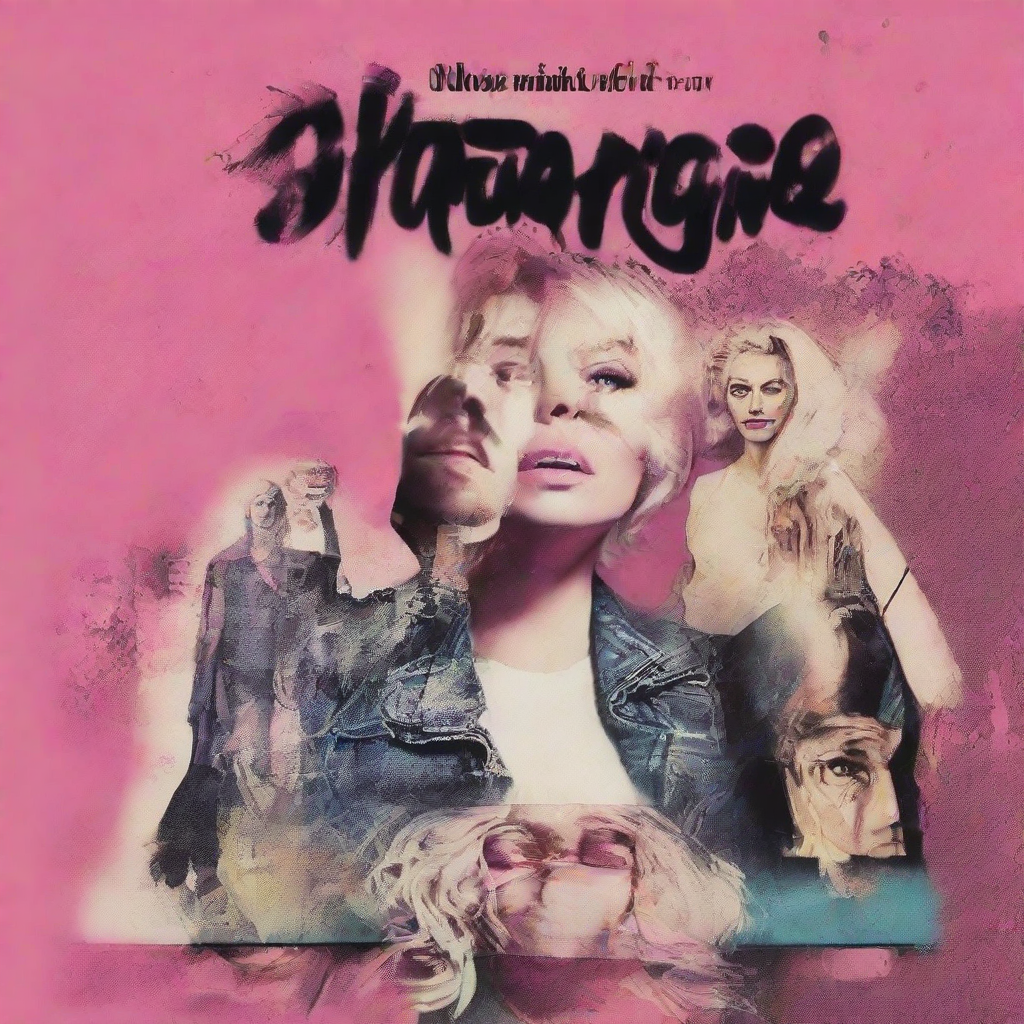

In [16]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0").to("cuda") 
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")

results = pipe(
    prompt="The poster of a movie called Blondie",
    num_inference_steps=4,
    guidance_scale=0.0,
)
results.images[0]

### Chapter 3 : App <a class="anchor" id="chapter3"></a>

1.1 - Search

In [ ]:
search_query = f"Batman"
endpoint_path = f"/search/movie"
endpoint = f"{API_BASE_URL}{endpoint_path}?api_key={API_KEY}&query={search_query}"
r = requests.get(endpoint)
print("réponse : ", r.status_code, "\n output : ", r.text)

réponse :  200 
 output :  {"page":1,"results":[{"adult":false,"backdrop_path":"/frDS8A5vIP927KYAxTVVKRIbqZw.jpg","genre_ids":[14,28,80],"id":268,"original_language":"en","original_title":"Batman","overview":"Batman must face his most ruthless nemesis when a deformed madman calling himself \"The Joker\" seizes control of Gotham's criminal underworld.","popularity":39.754,"poster_path":"/cij4dd21v2Rk2YtUQbV5kW69WB2.jpg","release_date":"1989-06-21","title":"Batman","video":false,"vote_average":7.219,"vote_count":7221},{"adult":false,"backdrop_path":"/bxxupqG6TBLKC60M6L8iOvbQEr6.jpg","genre_ids":[28,35,80],"id":2661,"original_language":"en","original_title":"Batman","overview":"The Dynamic Duo faces four super-villains who plan to hold the world for ransom with the help of a secret invention that instantly dehydrates people.","popularity":17.232,"poster_path":"/zzoPxWHnPa0eyfkMLgwbNvdEcVF.jpg","release_date":"1966-07-30","title":"Batman","video":false,"vote_average":6.3,"vote_count":789},

1.2 - Details

In [ ]:
## Avoir les détails d'un film dans une raw de df
movie_id = 299054
endpoint_path = f"/movie/{movie_id}"
endpoint = f"{API_BASE_URL}{endpoint_path}?api_key={API_KEY}"
r = requests.get(endpoint)
print("réponse : ", r.status_code, "\n output : ", r.text)

réponse :  200 
 output :  {"adult":false,"backdrop_path":"/wl4NWiZwpzZH67HiDgpDImLyds9.jpg","belongs_to_collection":{"id":126125,"name":"The Expendables Collection","poster_path":"/zwnCtNpHa6TFI1z20LPFgdY2Qks.jpg","backdrop_path":"/lA7oDSt6LkyDqtbFGbyuG0afmTI.jpg"},"budget":100000000,"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":53,"name":"Thriller"}],"homepage":"https://expendables.movie/","id":299054,"imdb_id":"tt3291150","original_language":"en","original_title":"Expend4bles","overview":"Armed with every weapon they can get their hands on and the skills to use them, The Expendables are the world’s last line of defense and the team that gets called when all other options are off the table. But new team members with new styles and tactics are going to give “new blood” a whole new meaning.","popularity":1075.05,"poster_path":"/iwsMu0ehRPbtaSxqiaUDQB9qMWT.jpg","production_companies":[{"id":1020,"logo_path":"/kuUIHNwMec4dwOLghDhhZJzHZTd.png","name":"Millennium M

1.3 - Trending

In [ ]:
## TV Shows
endpoint_path = f"/trending/tv/day"
page = 1
pages = f"{page}"
endpoint = f"{API_BASE_URL}{endpoint_path}?api_key={API_KEY}&page={pages}"
r = requests.get(endpoint) # json={"api_key": api_key})
print("réponse : ", r.status_code, "\n output : ", r.text)

réponse :  200 
 output :  {"page":1,"results":[{"adult":false,"backdrop_path":"/6SyHoFNHQWCLIQEc41uflHsaGwE.jpg","id":202411,"name":"Monarch: Legacy of Monsters","original_language":"en","original_name":"Monarch: Legacy of Monsters","overview":"After surviving Godzilla's attack on San Francisco, Cate is shaken yet again by a shocking secret. Amid monstrous threats, she embarks on a globetrotting adventure to learn the truth about her family—and the mysterious organization known as Monarch.","poster_path":"/uwrQHMnXD2DA1rvaMZk4pavZ3CY.jpg","media_type":"tv","genre_ids":[18,10765,10759],"popularity":175.668,"first_air_date":"2023-11-16","vote_average":8.3,"vote_count":15,"origin_country":["US"]},{"adult":false,"backdrop_path":"/wPEIbLDULBa4cZkfz4VekvI6e2T.jpg","id":155292,"name":"Scott Pilgrim Takes Off","original_language":"en","original_name":"Scott Pilgrim Takes Off","overview":"Scott Pilgrim meets the girl of his dreams, Ramona Flowers, only to find out her seven evil exes stand in 

1.4 - Top-rated

In [ ]:
endpoint_path = f"/tv/top_rated"
page = 1
pages = f"{page}"
endpoint = f"{API_BASE_URL}{endpoint_path}?api_key={API_KEY}&page={pages}"
r = requests.get(endpoint)
print("réponse : ", r.status_code, "\n output : ", r.text)

réponse :  200 
 output :  {"page":1,"results":[{"adult":false,"backdrop_path":"/9faGSFi5jam6pDWGNd0p8JcJgXQ.jpg","genre_ids":[18,80],"id":1396,"origin_country":["US"],"original_language":"en","original_name":"Breaking Bad","overview":"When Walter White, a New Mexico chemistry teacher, is diagnosed with Stage III cancer and given a prognosis of only two years left to live. He becomes filled with a sense of fearlessness and an unrelenting desire to secure his family's financial future at any cost as he enters the dangerous world of drugs and crime.","popularity":421.439,"poster_path":"/3xnWaLQjelJDDF7LT1WBo6f4BRe.jpg","first_air_date":"2008-01-20","name":"Breaking Bad","vote_average":8.894,"vote_count":12641},{"adult":false,"backdrop_path":"/rkB4LyZHo1NHXFEDHl9vSD9r1lI.jpg","genre_ids":[16,18,10765,10759],"id":94605,"origin_country":["US"],"original_language":"en","original_name":"Arcane","overview":"Amid the stark discord of twin cities Piltover and Zaun, two sisters fight on rival sid

# 
<a style='
font-size:23px;
text-decoration: none;
line-height: 16px;
display: flex;
color: #5B5B62;
padding: 10px;
justify-content: center;
align-items: center;'
href='https://github.com/alirani' 
target="_blank">
    <img alt='Created by Alirani' 
    style='
    display: inline;
    max-height: 50px;
    margin: 0px;
    margin-right: 7.5px;'
    src='https://i.postimg.cc/d17VnVgL/android-chrome-512x512.png'/>
    Created by 
    <span style='
    font-weight: 600;
    margin-left: 4px;'>
    Alirani</span>
</a>